In [1]:
import xml.etree.ElementTree as ElementTree
from collections import Counter

import os

In [2]:
base_path = 'C:/Users/DESKTOP/Desktop/RDD/RDD2022'

damageTypes=["D00", "D01", "D10", "D11", "D20", "D40", "D43", "D44"]

# govs corresponds to municipality name.
govs = ["China_Drone", "China_MotorBike","Czech","India","japan","Norway","United_States"]

In [3]:
# Initialize variables
total_images = 0
cls_names = []
xml_without_objects = 0
errors = 0
label_counter = Counter()

for gov in govs:
    gov_path = os.path.join(base_path, gov)
    
    # Walk through all subdirectories to find XML files
    xml_files_found = 0
    for root, dirs, files in os.walk(gov_path):
        for file in files:
            if file.endswith(".xml"):
                xml_file_path = os.path.join(root, file)
                total_images += 1
                xml_files_found += 1
                
                try:
                    with open(xml_file_path, 'r', encoding='utf-8') as infile_xml:
                        tree = ElementTree.parse(infile_xml)
                        root_elem = tree.getroot()
                        
                        # Count how many objects are in this file
                        objects = root_elem.findall('.//object')
                        if not objects:
                            xml_without_objects += 1
                            
                        for obj in root_elem.iter('object'):
                            name_elem = obj.find('name')
                            if name_elem is not None:
                                cls_name = name_elem.text
                                label_counter[cls_name] += 1
                                if cls_name not in cls_names:
                                    cls_names.append(cls_name)
                            else:
                                print(f"Warning: No name element found in object in file {xml_file_path}")
                                
                except Exception as e:
                    errors += 1
                    if errors <= 10:  # Limit the error output
                        print(f"Error parsing file {xml_file_path}: {e}")

# print("\nTotal")
# print("# of images：" + str(total_images))
# print("# of labels：" + str(len(cls_names)))
# print("XML files without objects: " + str(xml_without_objects))
# print("Failed to parse files: " + str(errors))
print("\nLabel distribution:")
for label, count in label_counter.most_common():
    print(f"{label}: {count}")


Label distribution:
D00: 26016
D10: 11830
D20: 10617
D40: 6544
D44: 5057
D50: 3581
Repair: 1046
D43: 793
D01: 179
D11: 45
Block crack: 3
D0w0: 1


<Axes: >

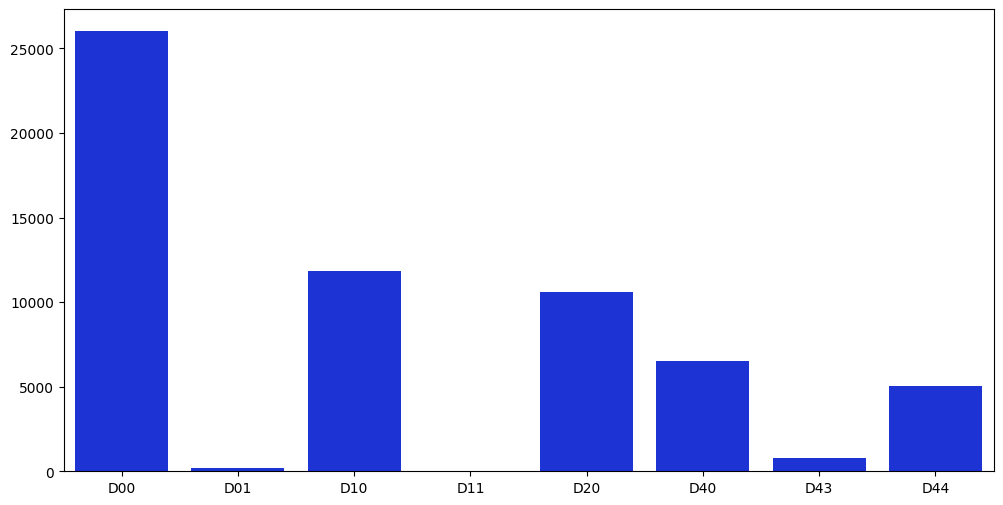

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create lists for the categories and counts
cls_count = []
for damageType in damageTypes:
    count = label_counter[damageType] 
    cls_count.append(count)

# Create the plot
plt.figure(figsize=(12, 6))
sns.set_palette("winter", len(damageTypes))
sns.barplot(x=damageTypes, y=cls_count)

In [5]:
# The number of each class labels for each municipality
for gov in govs:
    cls_names = []
    total_images = 0
    gov_path = os.path.join(base_path, gov)
    
    for root, dirs, files in os.walk(gov_path):
        for file in files:
            if file.endswith(".xml"):
                xml_file_path = os.path.join(root, file)
                total_images += 1
                
                try:
                    with open(xml_file_path, 'r', encoding='utf-8') as infile_xml:
                        tree = ElementTree.parse(infile_xml)
                        root_elem = tree.getroot()
                        
                        for obj in root_elem.iter('object'):
                            name_elem = obj.find('name')
                            if name_elem is not None:
                                cls_name = name_elem.text
                                cls_names.append(cls_name)
                            else:
                                print(f"Warning: No name element found in object in file {xml_file_path}")
                                
                except Exception as e:
                    print(f"Error parsing file {xml_file_path}: {e}")

    print(gov)
    print("# of images：" + str(total_images))
    print("# of labels：" + str(len(cls_names)))
    
    count_dict = Counter(cls_names)
    for damageType in damageTypes:
        print(str(damageType) + ' : ' + str(count_dict[damageType]))
        
    print('**************************************************')

China_Drone
# of images：2401
# of labels：3840
D00 : 1426
D01 : 0
D10 : 1263
D11 : 0
D20 : 293
D40 : 86
D43 : 0
D44 : 0
**************************************************
China_MotorBike
# of images：1977
# of labels：4927
D00 : 2678
D01 : 0
D10 : 1096
D11 : 0
D20 : 641
D40 : 235
D43 : 0
D44 : 0
**************************************************
Czech
# of images：2829
# of labels：1745
D00 : 988
D01 : 0
D10 : 399
D11 : 0
D20 : 161
D40 : 197
D43 : 0
D44 : 0
**************************************************
India
# of images：7706
# of labels：8203
D00 : 1555
D01 : 179
D10 : 68
D11 : 45
D20 : 2021
D40 : 3187
D43 : 57
D44 : 1062
**************************************************
japan
# of images：10506
# of labels：24754
D00 : 4049
D01 : 0
D10 : 3979
D11 : 0
D20 : 6199
D40 : 2243
D43 : 736
D44 : 3995
**************************************************
Norway
# of images：8161
# of labels：11229
D00 : 8570
D01 : 0
D10 : 1730
D11 : 0
D20 : 468
D40 : 461
D43 : 0
D44 : 0
******************************

In [6]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ElementTree

In [7]:
# Function to draw an image with bounding boxes
def draw_images(image_file, gov, damageType):
    # Construct paths for the image and its annotation
    img_path = os.path.join(base_path, gov, 'train/images', image_file.split('.')[0] + '.jpg')
    xml_path = os.path.join(base_path, gov, 'train/annotations/xmls', image_file)  # Added 'xmls' subdirectory
    
    # Read the image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Unable to load image at path {img_path}")
        return None
    
    # Parse the XML annotation file
    if os.path.exists(xml_path):
        with open(xml_path, 'r', encoding='utf-8') as infile_xml:
            tree = ElementTree.parse(infile_xml)
            root = tree.getroot()
            
            # Draw bounding boxes for the specified damage type
            for obj in root.iter('object'):
                name_elem = obj.find('name')
                if name_elem is not None and name_elem.text == damageType:
                    xmlbox = obj.find('bndbox')
                    xmin = int(float(xmlbox.find('xmin').text))
                    xmax = int(float(xmlbox.find('xmax').text))
                    ymin = int(float(xmlbox.find('ymin').text))
                    ymax = int(float(xmlbox.find('ymax').text))
                    
                    # Draw bounding box and label
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    cv2.putText(img, damageType, (xmin, ymin - 10), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
                    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)
    else:
        print(f"File not found: {xml_path}")
        return None
    
    return img


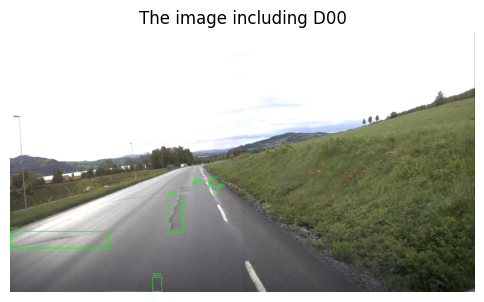

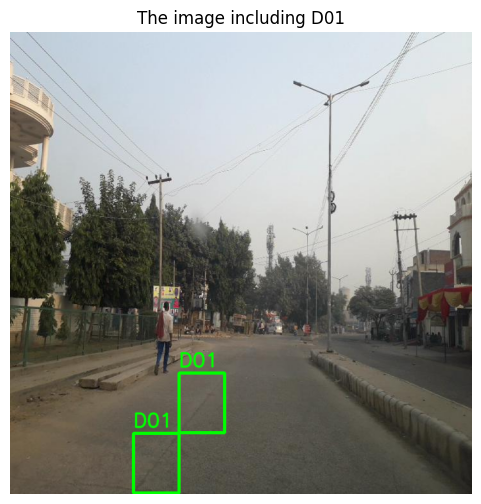

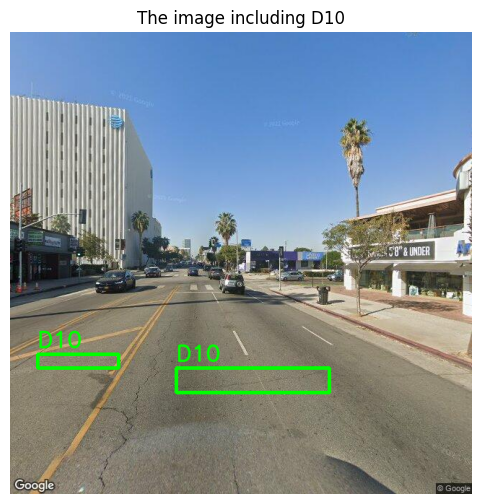

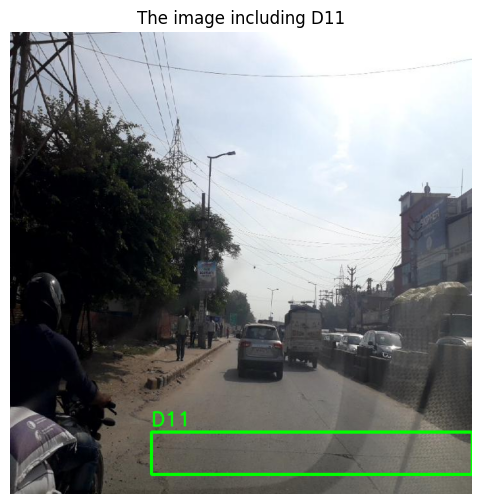

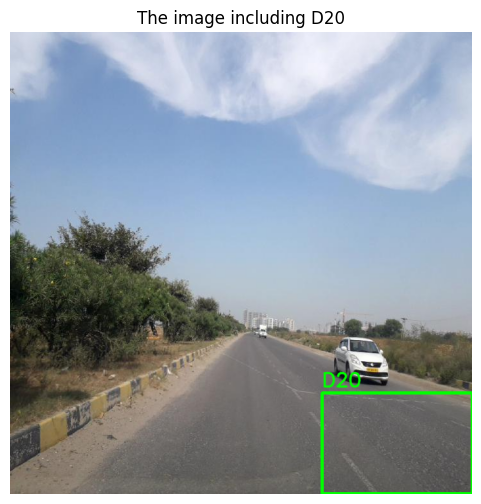

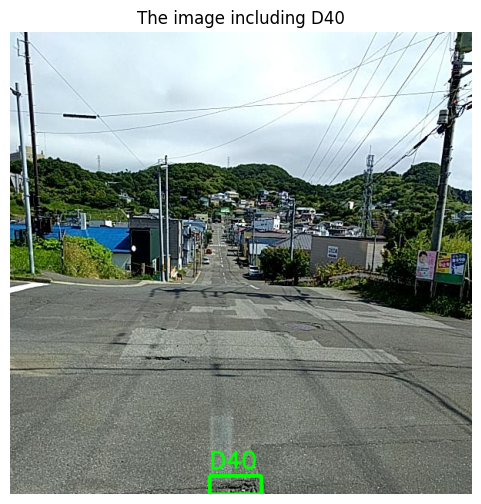

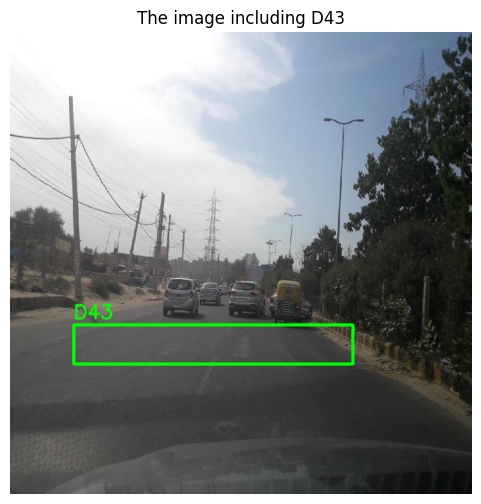

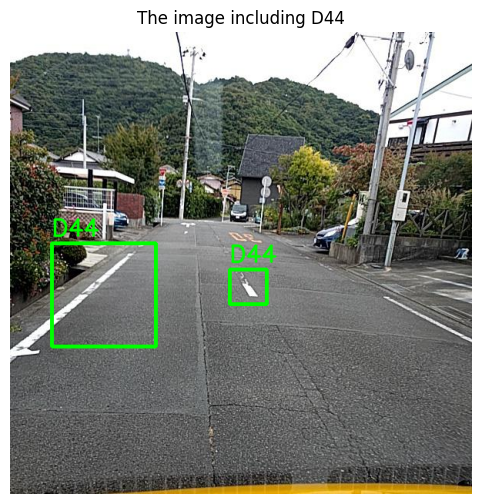

In [8]:

# Loop to plot one random image for each damage type
for damageType in damageTypes:
    tmp = []
    for gov in govs:
        annotations_path = os.path.join(base_path, gov, 'train/annotations')
        if os.path.exists(annotations_path):
            for root, dirs, files in os.walk(annotations_path):
                for file in files:
                    if file.endswith('.xml'):
                        xml_file_path = os.path.join(root, file)
                        try:
                            tree = ElementTree.parse(xml_file_path)
                            root_elem = tree.getroot()
                            for obj in root_elem.iter('object'):
                                name_elem = obj.find('name')
                                if name_elem is not None and name_elem.text == damageType:
                                    tmp.append((file, gov))  # Store both file and gov
                                    break
                        except Exception as e:
                            print(f"Error parsing file {xml_file_path}: {e}")
    
    # Randomly select one image
    if tmp:
        random.shuffle(tmp)
        selected_image, selected_gov = tmp[0]  # Extract both file and gov
        img = draw_images(selected_image, selected_gov, damageType)
        
        if img is not None:
            # Plot the image
            plt.figure(figsize=(6, 6))
            plt.axis('off')
            plt.title(f'The image including {damageType}')
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.show()
        else:
            print(f"Skipping display for {damageType} due to missing or invalid image.")
    else:
        print(f"No images found for {damageType}")